In [57]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 12))

import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')

from utils import display

<Figure size 864x864 with 0 Axes>

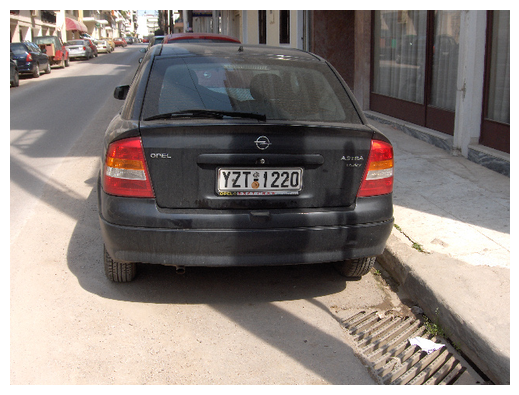

In [331]:
img = cv2.imread("images/car.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(img)
#sns.distplot(img.ravel())

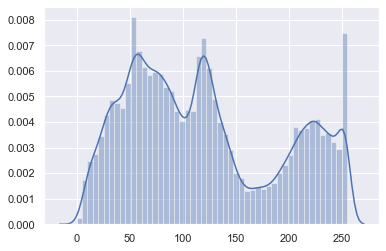

In [59]:
sns.distplot(img.ravel());

### Gamma Correction

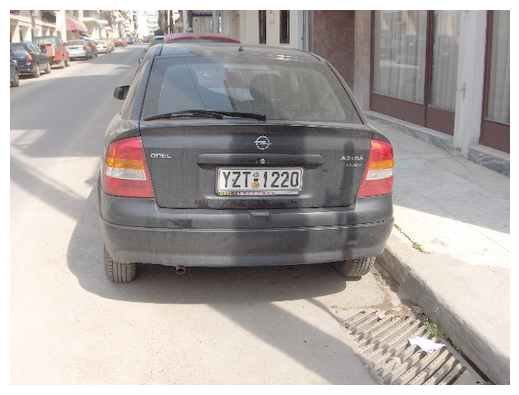

In [45]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    # creates a lookup table for all possible pixel values between 0-255
    table = np.array(
        [((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]
    )
    table = table.astype(np.uint8)
    return cv2.LUT(image, table)

# apply gamma correction
gamma_corrected = adjust_gamma(img, gamma=1.8)
display(gamma_corrected)

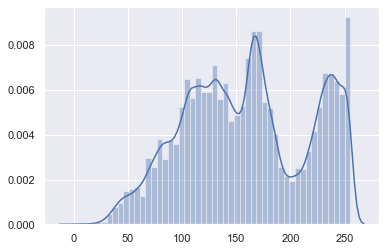

In [56]:
sns.distplot(gamma_corrected.ravel());

### Histogram Equalization

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is not the proper way for equalization of contrast. Equalization involves Intensity values of the image not the color components. So for a simple RGB color image, HE should not be applied individually on each channel. Rather, it should be applied such that intensity values are equalized without disturbing the color balance of the image. 

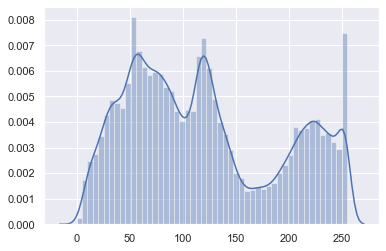

In [60]:
sns.distplot(img.ravel());

#### Intensity Image equalization 

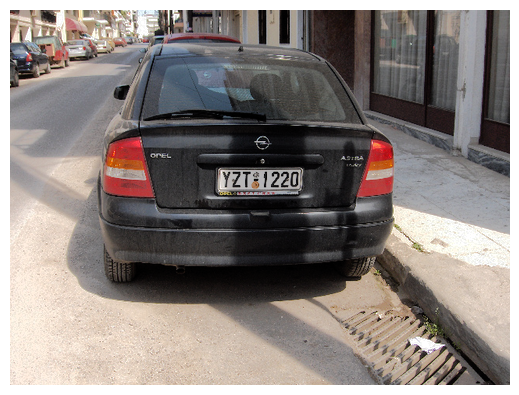

In [62]:
# 1. HSV/HSL 

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
v_eq = cv2.equalizeHist(v)
hsv_eq = cv2.merge([h, s, v_eq])
rgb_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)
display(rgb_eq)

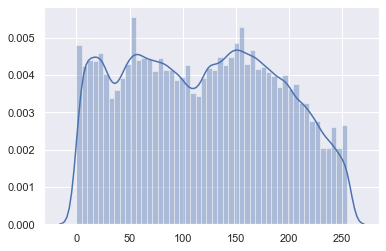

In [63]:
sns.distplot(rgb_eq.ravel());

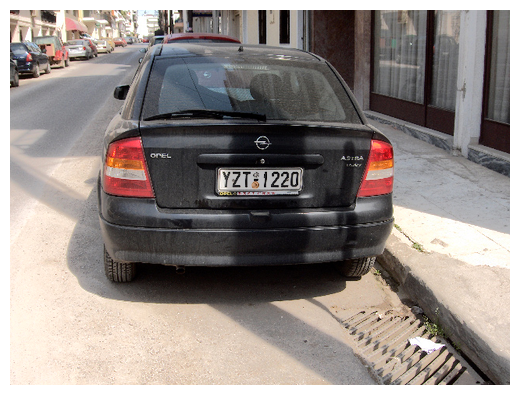

In [69]:
# 2. YCrCb 

YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(YCrCb)
Y_eq = cv2.equalizeHist(Y)
YCrCb_eq = cv2.merge([Y_eq, Cr, Cb])
rgb_eq = cv2.cvtColor(YCrCb_eq, cv2.COLOR_YCrCb2BGR)
display(rgb_eq)

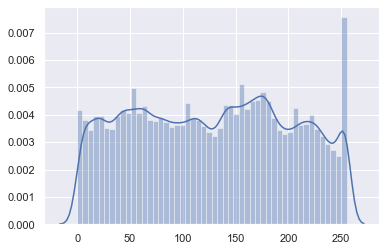

In [70]:
sns.distplot(rgb_eq.ravel());

#### Individual Channel Equalization

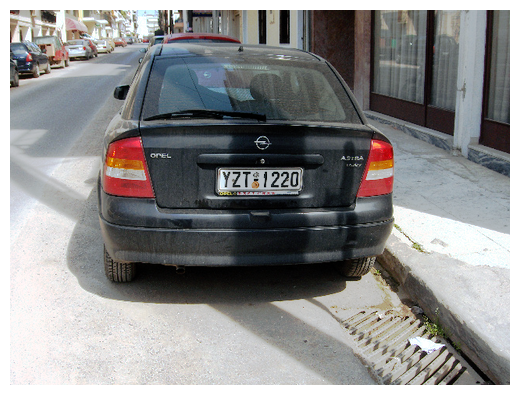

In [75]:
b, g, r = cv2.split(img)
b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

rgb_eq = cv2.merge([b_eq, g_eq, r_eq])
display(rgb_eq)

# NOTE: Notice the presence of false colors in the image 

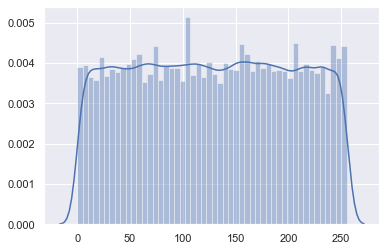

In [76]:
sns.distplot(rgb_eq.ravel());

### Inversion

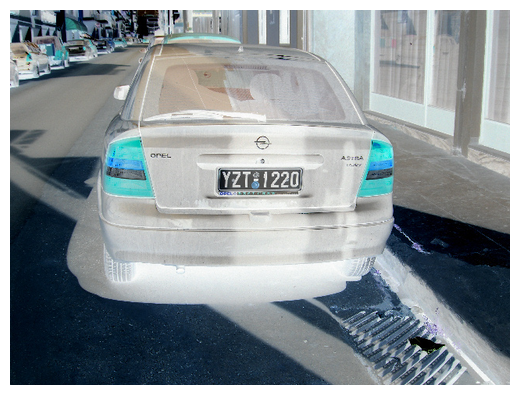

In [82]:
def inversion(img, blur=False):
    if blur:
        img = cv2.medianBlur(img, 3)
    return 255 - img

inverted = inversion(img)
display(inverted)

### Normalization

Min: 0.000, Max: 255.000, Mean: 120.084, Std: 71.135
Min: 0.000, Max: 255.000, Mean: 103.209, Std: 94.491


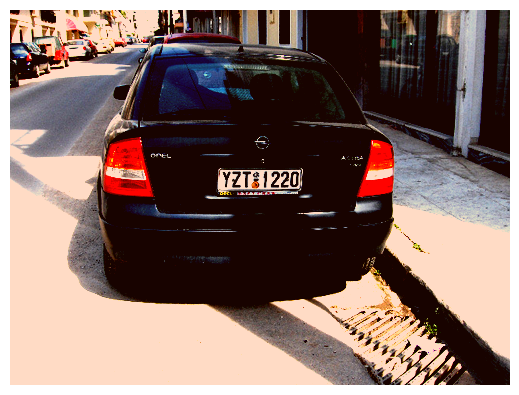

In [145]:
def normalize(img, offset=0.5):
    chs = []
    for ch in cv2.split(img):
        mu, sigma = cv2.meanStdDev(ch)
        chs.append(np.clip(ch, mu - offset*sigma, mu + offset*sigma).astype(np.uint8))
    clipped = cv2.merge(chs)
    return cv2.normalize(clipped, clipped, 0, 255, norm_type=cv2.NORM_MINMAX)

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(f"Min: {np.min(img):.3f}, Max: {np.max(img):.3f}, Mean: {np.mean(img):.3f}, Std: {np.std(img):.3f}")
normalized = normalize(img)
print(f"Min: {np.min(normalized):.3f}, Max: {np.max(normalized):.3f}, Mean: {np.mean(normalized):.3f}, Std: {np.std(normalized):.3f}")
display(normalized)

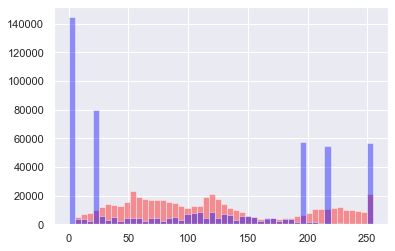

In [148]:
bins = 50
sns.distplot(img.ravel(), bins=bins, color="red", kde=False);
sns.distplot(normalized.ravel(), bins=bins, color="blue", kde=False);

### Sharpening 

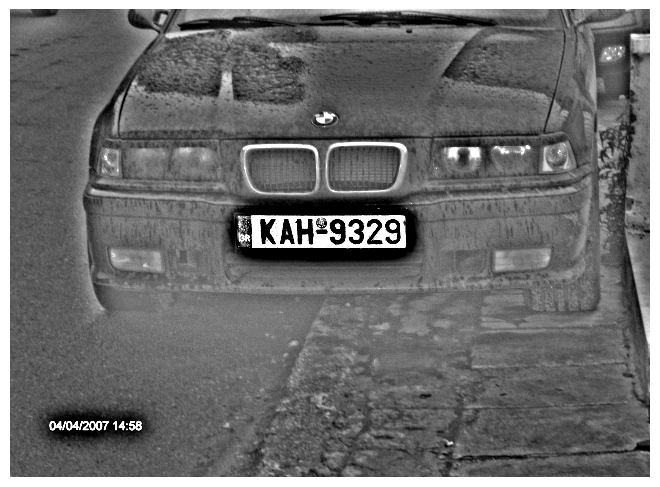

In [370]:
def sharpen(img, sigmaX=10, alpha=4, beta=-5, gamma=128):
    blur = cv2.GaussianBlur(img, (0, 0), sigmaX)
    # dst(I)=saturate(src1(I)∗alpha + src2(I)∗beta + gamma)
    sharped = cv2.addWeighted(img, alpha, blur, beta, gamma)
    return sharped

img = cv2.imread("./anpr/data/mwuqu.jpg")
#img = cv2.imread("./anpr/data/ii1zy.jpg")
img = imutils.resize(img, width=640) if img.shape[1] > 640 else img
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sharped_image = sharpen(gray, sigmaX=10, beta=-5, gamma=128)
display(sharped_image, flip=False, cmap="gray")

7.75 847.0 1116 0.76
5.857142857142857 3752.5 4592 0.82
1.2857142857142858 48.0 63 0.76
0.7142857142857143 20.5 35 0.59
0.7142857142857143 20.5 35 0.59


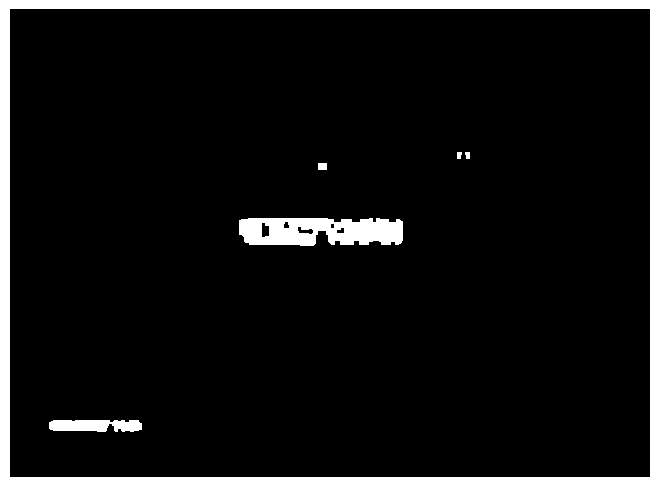

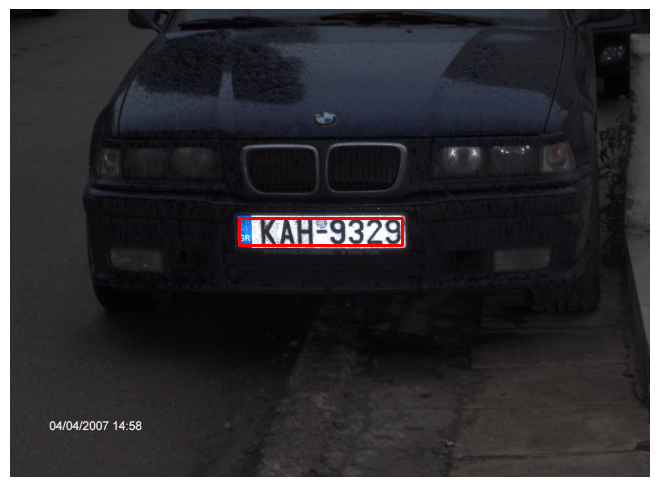

In [379]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
square_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


# apply blackhat to reveal darker regions on light background
blackhat = cv2.morphologyEx(sharped_image, cv2.MORPH_BLACKHAT, rect_kernel)

# find regions in the image that are light
# apply morphology CLOSE
light = cv2.morphologyEx(sharped_image, cv2.MORPH_CLOSE, square_kernel)
# threshold the image between 50 and 255 because our target plates are mostly white in color
light = cv2.threshold(light, 50, 255, cv2.THRESH_BINARY)[1]

# compute the Scharr gradient representation of the blackhat image in the x-direction
grad_x = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad_x = np.absolute(grad_x)
min_val, max_val = (np.min(grad_x), np.max(grad_x))
# min/max scaling to [0, 255]
grad_x = (255 * ((grad_x - min_val) / (max_val - min_val))).astype("uint8")

# blur the gradient representation,
grad_x = cv2.GaussianBlur(grad_x, (5, 5), 0)
# apply a morphology CLOSE
grad_x = cv2.morphologyEx(grad_x, cv2.MORPH_CLOSE, rect_kernel)
# threshold the image using Otsu's method
thresh = cv2.threshold(grad_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# perform a series of erosions and dilations on the image
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# take the bitwise 'and' between the 'light' regions of the image
thresh = cv2.bitwise_and(thresh, thresh, mask=light)
# another series of erosions and dilations
thresh = cv2.dilate(thresh, None, iterations=2)
thresh = cv2.erode(thresh, None, iterations=1)
display(thresh, flip=False, cmap="gray")




# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
regions = []
# loop over the contours
for c in cnts:
    # grab the bounding box associated with the contour and compute the area and
    # aspect ratio
    (w, h) = cv2.boundingRect(c)[2:]
    aspect_ratio = w / float(h)

    # calculate *extent* for additional filtering
    shape_area = cv2.contourArea(c)
    bbox_area = w * h
    extent = np.round((shape_area / float(bbox_area)), 2)

    # compute the rotated bounding box of the region
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))

    # ensure the aspect ratio, width, and height of the bounding box fall within
    # tolerable limits, then update the list of license plate regions
    if (3 < aspect_ratio < 6) and h > 20 and w > 60 and extent > 0.50:
        regions.append(box)
        
img1 = img.copy()     
for lp_box in regions:
    lp_box = np.array(lp_box).reshape((-1, 1, 2)).astype(np.int32)
    cv2.drawContours(img1, [lp_box], -1, (0, 0, 255), 2)
    
display(img1)
